In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel, hyperparameters):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)

        # fix hyperparameters 
        self.covar_module.base_kernel.lengthscale = hyperparameters['lengthscale'] 
        self.covar_module.outputscale = hyperparameters['outputscale']
        self.covar_module.base_kernel.noise = hyperparameters['noise']

        self.covar_module.base_kernel.raw_lengthscale.requires_grad = False
        self.covar_module.raw_outputscale.requires_grad = False
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## 2D dataset:

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_samples = 100
input_dim = 2
# torch.manual_seed(0)

lengthscale = torch.tensor([0.5, 0.3], device=device)
outputscale = torch.tensor(1.8, device=device)
noise = 0.1

hyperparameters = {
    'lengthscale': lengthscale,
    'outputscale': outputscale,
    'noise': noise
}



/home/sanket/Projects/gp_ws/gpenv/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [11]:
train_x_np = np.random.uniform(low=-2.0, high=2.0, size=(num_samples, 2))
train_x = torch.tensor(train_x_np, dtype=torch.float32, device=device)

x1 = 4.0 * train_x_np[:, 0] - 2.0
x2 = 4.0 * train_x_np[:, 1] - 2.0

fact1a = (x1 + x2 + 1)**2
fact1b = 19 - 14*x1 + 3*x1**2 - 14*x2 + 6*x1*x2 + 3*x2**2
fact1 = 1 + fact1a * fact1b

fact2a = (2*x1 - 3*x2)**2
fact2b = 18 - 32*x1 + 12*x1**2 + 48*x2 - 36*x1*x2 + 27*x2**2
fact2 = 30 + fact2a * fact2b

prod = fact1 * fact2

train_y_np = (np.log(prod) - 8.693) / 2.427

train_y = torch.tensor(train_y_np, dtype=torch.float32, device=device)

In [12]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = noise
likelihood.raw_noise.requires_grad = False

kernel = gpytorch.kernels.RBFKernel(ard_num_dims=input_dim)
kernel.lengthscale = lengthscale
kernel.outputscale = outputscale

model = ExactGPModel(train_x, train_y, likelihood, kernel, hyperparameters)

model.to(device)
likelihood.to(device)


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [13]:
# print model hyperparameters
if model.covar_module.base_kernel.lengthscale.numel() > 1:
        print(f"Lengthscale:", model.covar_module.base_kernel.lengthscale.cpu().detach().numpy())  # Print all lengthscale values
else:
    print(f"Lengthscale:", model.covar_module.base_kernel.lengthscale.item())  # Print single lengthscale value

print(f"Outputscale:", model.covar_module.outputscale.item())
print(f"Noise:", model.likelihood.noise.item())

Lengthscale: [[0.49999997 0.30000004]]
Outputscale: 1.7999999523162842
Noise: 0.09999999403953552


In [14]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

shape of grid points tensor: torch.Size([32400, 2])


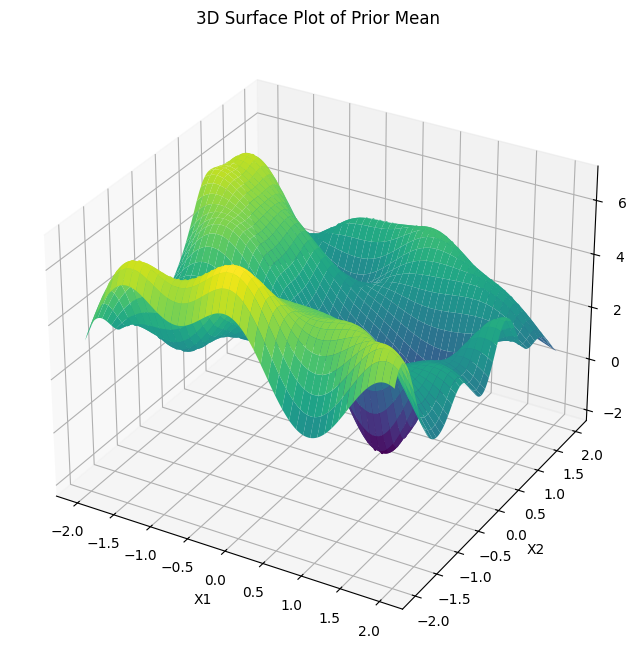

In [33]:
# plot a 3d surface of the prior
x1_range = np.linspace(-2, 2, 180)
x2_range = np.linspace(-2, 2, 180)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
grid_points = np.vstack([x1_grid.ravel(), x2_grid.ravel()]).T

test_x = torch.tensor(grid_points, dtype=torch.float32, device=device)  

print("shape of grid points tensor:", test_x.shape)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prior_grid = model(test_x)
    test_y = prior_grid.mean.cpu().numpy().reshape(x1_grid.shape)
    prior_variance = prior_grid.variance.cpu().numpy().reshape(x1_grid.shape)

# plot the prior mean
fig = plt.figure(figsize=(10, 8))   
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_grid, x2_grid, test_y, cmap='viridis', edgecolor='none')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Prior Mean')
ax.set_title('3D Surface Plot of Prior Mean')
plt.show()

In [27]:
# save this dataset test_x and test_y as csv files
np.savetxt("datase3x_2d_32400.csv", test_x.cpu().numpy(), delimiter=",")

test_y = test_y.flatten()
np.savetxt("dataset3y_2d_32400.csv", test_y, delimiter=",")

## Dataset 1:

In [38]:
# load the dataset from csv files
loaded_test_x = np.loadtxt("dataset1/dataset1x_2d_32400.csv", delimiter=",")
loaded_test_y = np.loadtxt("dataset1/dataset1y_2d_32400.csv", delimiter=",")

print("Loaded test_x shape:", loaded_test_x.shape)
print("Loaded test_y shape:", loaded_test_y.shape)

Loaded test_x shape: (32400, 2)
Loaded test_y shape: (32400,)


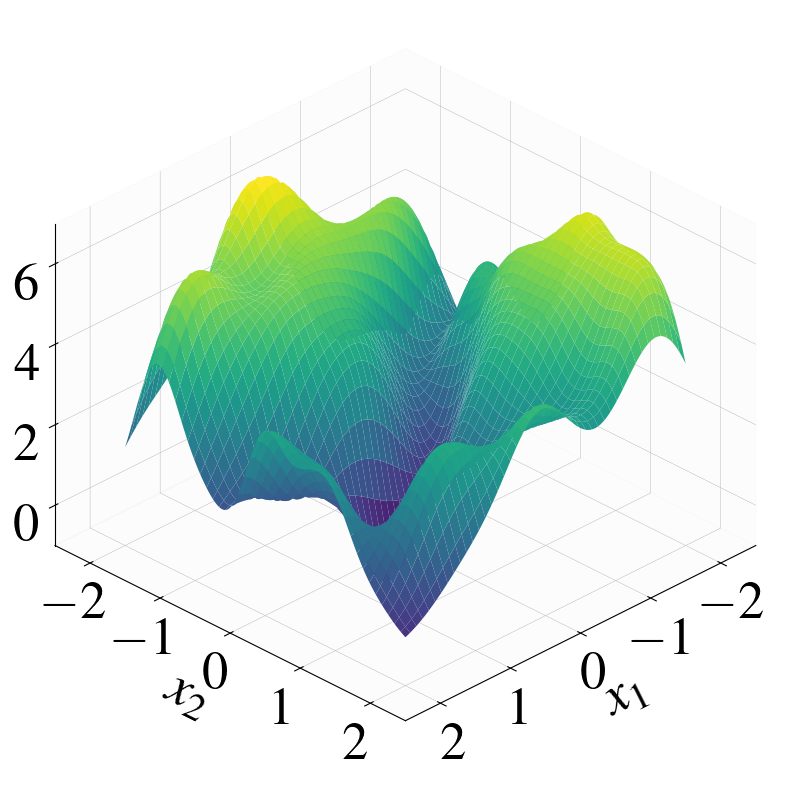

In [39]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
})

# plot the loaded dataset
x1_range = np.linspace(-2, 2, 180)
x2_range = np.linspace(-2, 2, 180)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

loaded_test_x = torch.tensor(loaded_test_x, dtype=torch.float32, device=device)
loaded_test_y = torch.tensor(loaded_test_y, dtype=torch.float32, device=device)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')
surf = ax.plot_surface(loaded_test_x[:, 0].cpu().numpy().reshape(x1_grid.shape), 
               loaded_test_x[:, 1].cpu().numpy().reshape(x2_grid.shape), 
               loaded_test_y.cpu().numpy().reshape(x1_grid.shape),
               cmap='viridis', 
               edgecolor='none')

# Add colorbar for Z values
# cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
# cbar.set_label('Output (Prior Mean)', fontsize=12)

ax.set_xlabel(r'$x_1$', fontsize=38, labelpad=15)
ax.set_ylabel(r'$x_2$', fontsize=38, labelpad=15)
# ax.set_zlabel('Prior Mean')
# ax.set_title('3D Surface Plot of Loaded Prior Mean')

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-1, 7)

# --- Tick spacing and size ---
x_ticks = np.arange(-2, 2.1, 1.0)
y_ticks = np.arange(-2, 2.1, 1.0)
# z_min, z_max = loaded_test_y.min().item(), loaded_test_y.max().item()
# z_ticks = np.linspace(z_min, z_max, 6)
z_ticks = np.array([0, 2, 4, 6])  # Adjust based on expected range

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_zticks(z_ticks)

# Set tick label font sizes (works reliably in 3D)
ax.tick_params(axis='x', labelsize=38)
ax.tick_params(axis='y', labelsize=38)
ax.tick_params(axis='z', labelsize=38)

ax.view_init(elev=30, azim=45) 

# Make panes (background walls) slightly transparent
ax.xaxis.pane.set_alpha(0.1)
ax.yaxis.pane.set_alpha(0.1)
ax.zaxis.pane.set_alpha(0.1)

# Optionally, set pane colors (light gray for soft contrast)
ax.xaxis.pane.set_color((0.9, 0.9, 0.9, 0.1))
ax.yaxis.pane.set_color((0.9, 0.9, 0.9, 0.1))
ax.zaxis.pane.set_color((0.9, 0.9, 0.9, 0.1))

# Adjust grid line thickness and opacity
ax.xaxis._axinfo["grid"]['linewidth'] = 0.3
ax.yaxis._axinfo["grid"]['linewidth'] = 0.3
ax.zaxis._axinfo["grid"]['linewidth'] = 0.3

plt.show()

# save image as png high quality
fig.savefig("dataset_1.png", dpi=300, bbox_inches='tight')
fig.savefig("dataset_1.pdf", dpi=300, bbox_inches='tight')

## Dataset 2:

In [40]:
# load the dataset from csv files
loaded_test_x = np.loadtxt("dataset2/dataset2x_2d_32400.csv", delimiter=",")
loaded_test_y = np.loadtxt("dataset2/dataset2y_2d_32400.csv", delimiter=",")

print("Loaded test_x shape:", loaded_test_x.shape)
print("Loaded test_y shape:", loaded_test_y.shape)

Loaded test_x shape: (32400, 2)
Loaded test_y shape: (32400,)


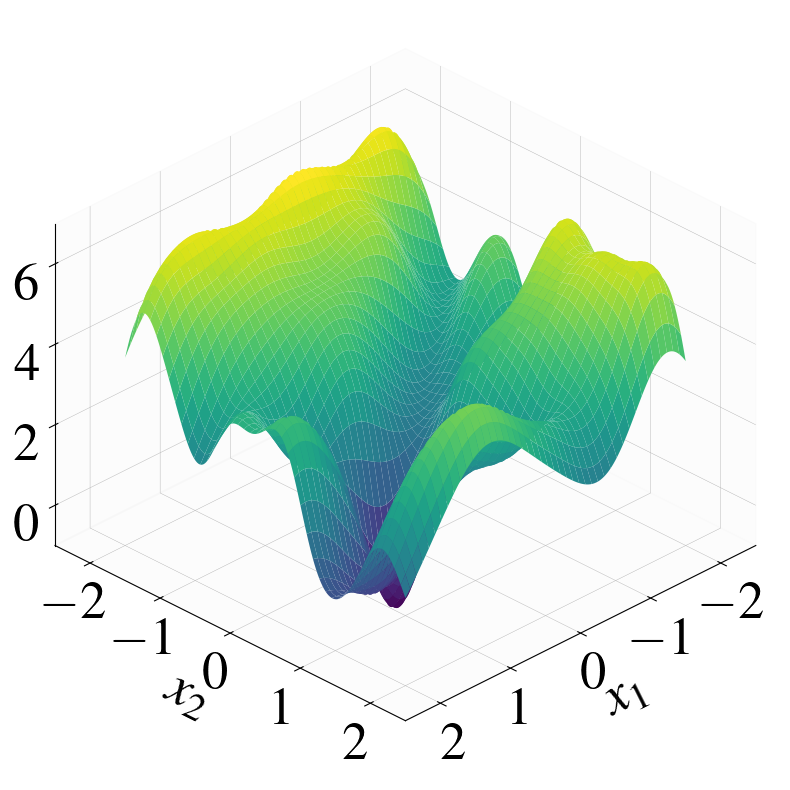

In [41]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
})

# plot the loaded dataset
x1_range = np.linspace(-2, 2, 180)
x2_range = np.linspace(-2, 2, 180)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

loaded_test_x = torch.tensor(loaded_test_x, dtype=torch.float32, device=device)
loaded_test_y = torch.tensor(loaded_test_y, dtype=torch.float32, device=device)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')
surf = ax.plot_surface(loaded_test_x[:, 0].cpu().numpy().reshape(x1_grid.shape), 
               loaded_test_x[:, 1].cpu().numpy().reshape(x2_grid.shape), 
               loaded_test_y.cpu().numpy().reshape(x1_grid.shape),
               cmap='viridis', 
               edgecolor='none')

# Add colorbar for Z values
# cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
# cbar.set_label('Output (Prior Mean)', fontsize=12)

ax.set_xlabel(r'$x_1$', fontsize=38, labelpad=15)
ax.set_ylabel(r'$x_2$', fontsize=38, labelpad=15)
# ax.set_zlabel('Prior Mean')
# ax.set_title('3D Surface Plot of Loaded Prior Mean')

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-1, 7)

# --- Tick spacing and size ---
x_ticks = np.arange(-2, 2.1, 1.0)
y_ticks = np.arange(-2, 2.1, 1.0)
# z_min, z_max = loaded_test_y.min().item(), loaded_test_y.max().item()
# z_ticks = np.linspace(z_min, z_max, 6)
z_ticks = np.array([0, 2, 4, 6])  # Adjust based on expected range

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_zticks(z_ticks)

# Set tick label font sizes (works reliably in 3D)
ax.tick_params(axis='x', labelsize=38)
ax.tick_params(axis='y', labelsize=38)
ax.tick_params(axis='z', labelsize=38)

ax.view_init(elev=30, azim=45) 

# Make panes (background walls) slightly transparent
ax.xaxis.pane.set_alpha(0.1)
ax.yaxis.pane.set_alpha(0.1)
ax.zaxis.pane.set_alpha(0.1)

# Optionally, set pane colors (light gray for soft contrast)
ax.xaxis.pane.set_color((0.9, 0.9, 0.9, 0.1))
ax.yaxis.pane.set_color((0.9, 0.9, 0.9, 0.1))
ax.zaxis.pane.set_color((0.9, 0.9, 0.9, 0.1))

# Adjust grid line thickness and opacity
ax.xaxis._axinfo["grid"]['linewidth'] = 0.3
ax.yaxis._axinfo["grid"]['linewidth'] = 0.3
ax.zaxis._axinfo["grid"]['linewidth'] = 0.3

plt.show()

# save image as png high quality
fig.savefig("dataset_2.png", dpi=300, bbox_inches='tight')
fig.savefig("dataset_2.pdf", dpi=300, bbox_inches='tight')

## Dataset 3:

In [42]:
# load the dataset from csv files
loaded_test_x = np.loadtxt("dataset3/dataset3x_2d_32400.csv", delimiter=",")
loaded_test_y = np.loadtxt("dataset3/dataset3y_2d_32400.csv", delimiter=",")

print("Loaded test_x shape:", loaded_test_x.shape)
print("Loaded test_y shape:", loaded_test_y.shape)



Loaded test_x shape: (32400, 2)
Loaded test_y shape: (32400,)


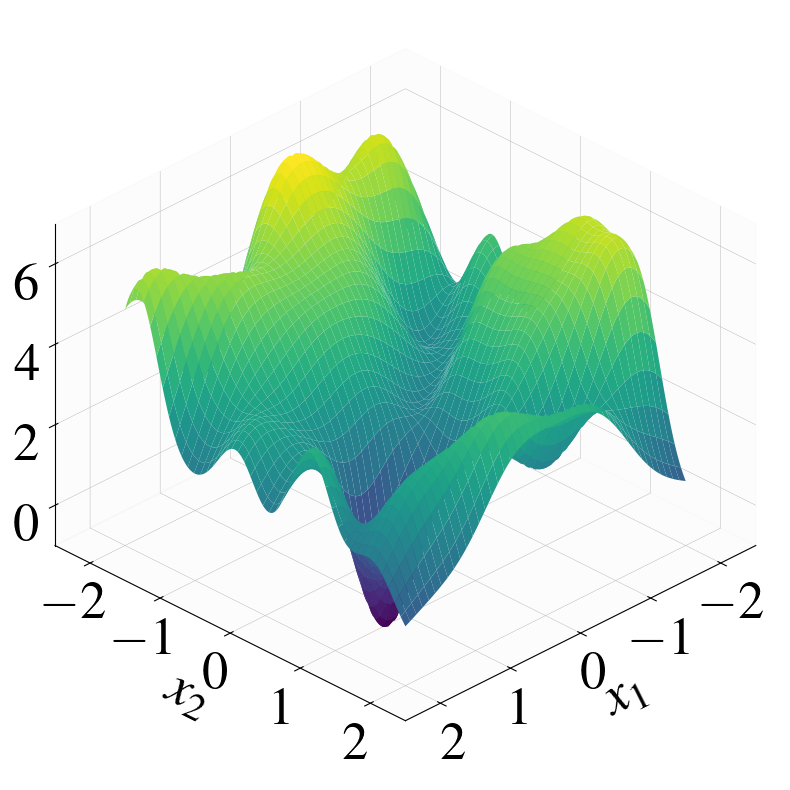

In [43]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
})

# plot the loaded dataset
x1_range = np.linspace(-2, 2, 180)
x2_range = np.linspace(-2, 2, 180)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

loaded_test_x = torch.tensor(loaded_test_x, dtype=torch.float32, device=device)
loaded_test_y = torch.tensor(loaded_test_y, dtype=torch.float32, device=device)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')
surf = ax.plot_surface(loaded_test_x[:, 0].cpu().numpy().reshape(x1_grid.shape), 
               loaded_test_x[:, 1].cpu().numpy().reshape(x2_grid.shape), 
               loaded_test_y.cpu().numpy().reshape(x1_grid.shape),
               cmap='viridis', 
               edgecolor='none')

# Add colorbar for Z values
# cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
# cbar.set_label('Output (Prior Mean)', fontsize=12)

ax.set_xlabel(r'$x_1$', fontsize=38, labelpad=15)
ax.set_ylabel(r'$x_2$', fontsize=38, labelpad=15)
# ax.set_zlabel('Prior Mean')
# ax.set_title('3D Surface Plot of Loaded Prior Mean')

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-1, 7)

# --- Tick spacing and size ---
x_ticks = np.arange(-2, 2.1, 1.0)
y_ticks = np.arange(-2, 2.1, 1.0)
# z_min, z_max = loaded_test_y.min().item(), loaded_test_y.max().item()
# z_ticks = np.linspace(z_min, z_max, 6)
z_ticks = np.array([0, 2, 4, 6])  # Adjust based on expected range

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_zticks(z_ticks)

# Set tick label font sizes (works reliably in 3D)
ax.tick_params(axis='x', labelsize=38)
ax.tick_params(axis='y', labelsize=38)
ax.tick_params(axis='z', labelsize=38)

ax.view_init(elev=30, azim=45) 

# Make panes (background walls) slightly transparent
ax.xaxis.pane.set_alpha(0.1)
ax.yaxis.pane.set_alpha(0.1)
ax.zaxis.pane.set_alpha(0.1)

# Optionally, set pane colors (light gray for soft contrast)
ax.xaxis.pane.set_color((0.9, 0.9, 0.9, 0.1))
ax.yaxis.pane.set_color((0.9, 0.9, 0.9, 0.1))
ax.zaxis.pane.set_color((0.9, 0.9, 0.9, 0.1))

# Adjust grid line thickness and opacity
ax.xaxis._axinfo["grid"]['linewidth'] = 0.3
ax.yaxis._axinfo["grid"]['linewidth'] = 0.3
ax.zaxis._axinfo["grid"]['linewidth'] = 0.3

plt.show()

# save image as png high quality
fig.savefig("dataset_3.png", dpi=300, bbox_inches='tight')
fig.savefig("dataset_3.pdf", dpi=300, bbox_inches='tight')

## Combined plot:

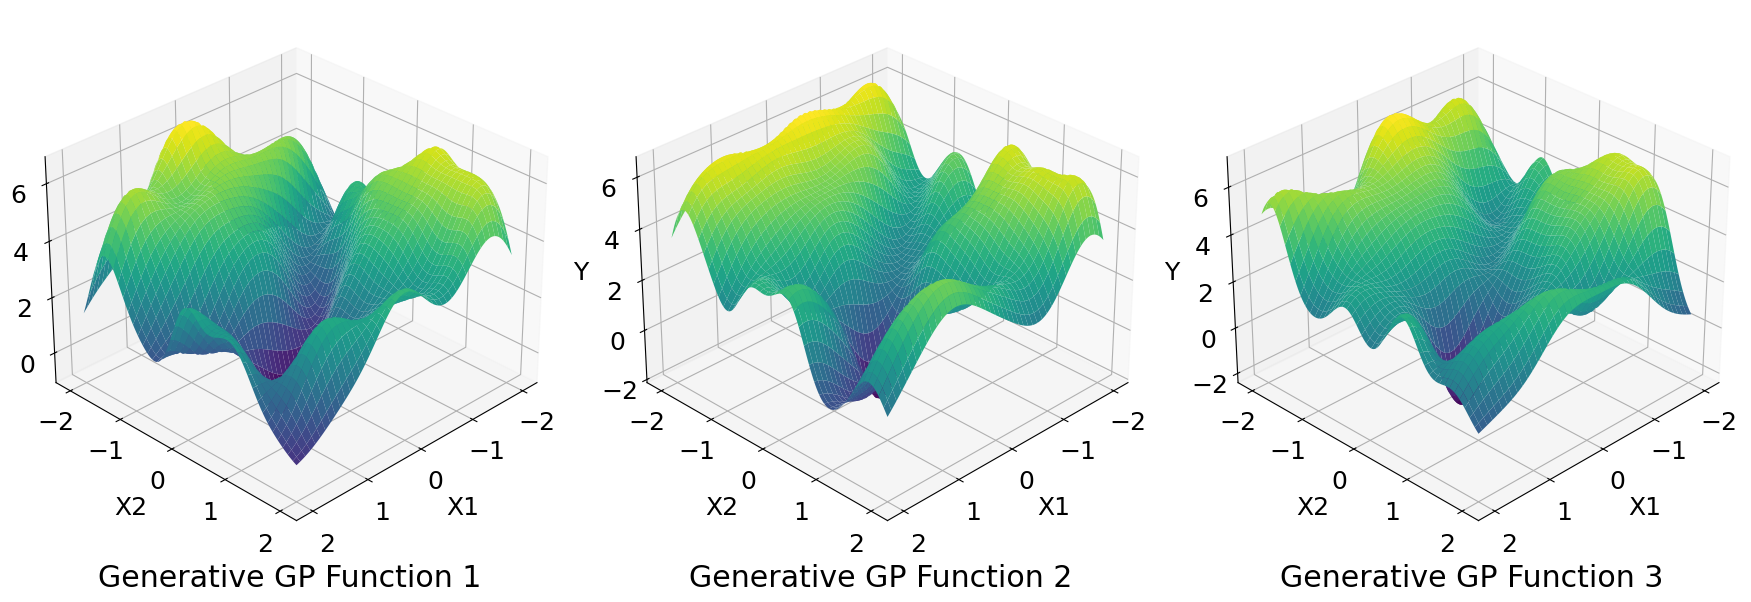

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch

img_width = 18
img_height = 4

plt.rcParams["figure.figsize"] = [img_width, img_height]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = 18     #### If image is not good just make it 14 run and again make it 20
# plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = 'Times New Roman'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = [1, 2, 3]

fig = plt.figure(figsize=(18, 6))  # Wider for horizontal layout

for i, id in enumerate(dataset):
    # Load same file for demo — replace with actual paths per id if needed
    loaded_test_x = np.loadtxt(f"dataset{id}/dataset{id}x_2d_32400.csv", delimiter=",")
    loaded_test_y = np.loadtxt(f"dataset{id}/dataset{id}y_2d_32400.csv", delimiter=",")

    x1_range = np.linspace(-2, 2, 180)
    x2_range = np.linspace(-2, 2, 180)
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

    loaded_test_x = torch.tensor(loaded_test_x, dtype=torch.float32, device=device)
    loaded_test_y = torch.tensor(loaded_test_y, dtype=torch.float32, device=device)

    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    ax.plot_surface(
        loaded_test_x[:, 0].cpu().numpy().reshape(x1_grid.shape),
        loaded_test_x[:, 1].cpu().numpy().reshape(x2_grid.shape),
        loaded_test_y.cpu().numpy().reshape(x1_grid.shape),
        cmap='viridis', edgecolor='none'
    )

    ax.set_title(f'Generative GP Function {id}', y=-0.09)
    ax.set_xlabel(r'X1', labelpad=12)
    ax.set_ylabel(r'X2', labelpad=12)
    ax.set_zlabel(r'Y')
    ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


## 3D dataset:

In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel, hyperparameters):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))

        self.covar_module.base_kernel.lengthscale = hyperparameters['lengthscale'] 
        self.covar_module.outputscale = hyperparameters['outputscale']
        self.covar_module.base_kernel.noise = hyperparameters['noise']

        self.covar_module.base_kernel.raw_lengthscale.requires_grad = False
        self.covar_module.raw_outputscale.requires_grad = False
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
device = 'cpu' #torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_samples = 100
input_dim = 3

lengthscale = torch.tensor([0.5, 0.3, 1.2], device=device)
outputscale = torch.tensor(1.8, device=device)
noise = 0.1

hyperparameters = {
    'lengthscale': lengthscale,
    'outputscale': outputscale,
    'noise': noise
}

train_x = None
train_y = None


In [4]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = noise
likelihood.raw_noise.requires_grad = False

kernel = gpytorch.kernels.RBFKernel(ard_num_dims=input_dim)
kernel.lengthscale = lengthscale
kernel.outputscale = outputscale

model = ExactGPModel(train_x, train_y, likelihood, kernel, hyperparameters)

model.to(device)
likelihood.to(device)

hypers = {
    # We won't be using the likelihood so we don't need to initialize the noise
    'covar_module.base_kernel.lengthscale': lengthscale,
    'covar_module.outputscale': outputscale,
}

model.initialize(**hypers)

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [12]:
N = 16900
test_x = -2 + 4 * torch.rand(N, 3, device=device) # Generate random test points in 3D

model.eval()
with gpytorch.settings.prior_mode(True):
    test_y = model(test_x).sample()


In [13]:
if model.covar_module.base_kernel.lengthscale.numel() > 1:
        print(f"Lengthscale:", model.covar_module.base_kernel.lengthscale.cpu().detach().numpy())  # Print all lengthscale values
else:
    print(f"Lengthscale:", model.covar_module.base_kernel.lengthscale.item())  # Print single lengthscale value

print(f"Outputscale:", model.covar_module.outputscale.item())
print(f"Noise:", model.likelihood.noise.item())

Lengthscale: [[0.5        0.30000004 1.2       ]]
Outputscale: 1.7999999523162842
Noise: 0.09999999403953552


In [14]:
print("test_y shape:", test_y.shape)
print("test x shape:", test_x.shape)

print("test x ", test_x)

test_y shape: torch.Size([16900])
test x shape: torch.Size([16900, 3])
test x  tensor([[ 1.2385, -1.0813, -1.0467],
        [ 1.6353, -1.4511,  1.8925],
        [ 0.2053, -0.1481,  0.0534],
        ...,
        [ 0.8879,  0.8037,  0.5317],
        [ 0.9743, -0.3791,  0.9760],
        [ 0.7667,  0.4551, -1.0037]])


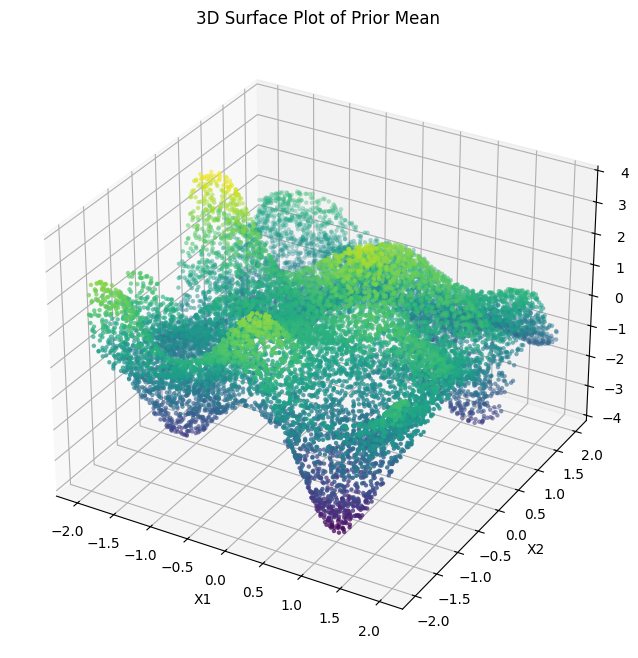

In [15]:
# plot a 3d surface of the prior
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_x[:, 0].cpu().numpy(), test_x[:, 1].cpu().numpy(), test_y.cpu().numpy(), 
           c=test_y.cpu().numpy(), cmap='viridis', edgecolor='none', s=10)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Prior Mean')
ax.set_title('3D Surface Plot of Prior Mean')
plt.show()

In [16]:
np.savetxt("dataset5x_3d_16900.csv", test_x.cpu().numpy(), delimiter=",")

test_y = test_y.flatten()
np.savetxt("dataset5y_3d_16900.csv", test_y.cpu().numpy(), delimiter=",")

In [10]:
import numpy as np

def softmax_numpy(x, axis=-1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

In [11]:
x = np.array([0.7, 0.3, 1.2])
print(softmax_numpy(x)) 

[0.30129182 0.20196195 0.49674623]


## 6D dataset:

In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel, hyperparameters):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=6))

        self.covar_module.base_kernel.lengthscale = hyperparameters['lengthscale'] 
        self.covar_module.outputscale = hyperparameters['outputscale']
        self.covar_module.base_kernel.noise = hyperparameters['noise']

        self.covar_module.base_kernel.raw_lengthscale.requires_grad = False
        self.covar_module.raw_outputscale.requires_grad = False
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
device = 'cpu'
num_samples = 100
input_dim = 6
# torch.manual_seed(0)

lengthscale = torch.tensor([0.5, 0.3, 1.2, 0.45, 1.62, 2.0], device=device)
outputscale = torch.tensor(1.8, device=device)
noise = 0.1

hyperparameters = {
    'lengthscale': lengthscale,
    'outputscale': outputscale,
    'noise': noise
}

train_x = None
train_y = None

In [7]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = noise
likelihood.raw_noise.requires_grad = False

kernel = gpytorch.kernels.RBFKernel(ard_num_dims=input_dim)
kernel.lengthscale = lengthscale
kernel.outputscale = outputscale

model = ExactGPModel(train_x, train_y, likelihood, kernel, hyperparameters)

model.to(device)
likelihood.to(device)

hypers = {
    # We won't be using the likelihood so we don't need to initialize the noise
    'covar_module.base_kernel.lengthscale': lengthscale,
    'covar_module.outputscale': outputscale,
}

model.initialize(**hypers)

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [17]:
N = 32400
test_x = -2 + 4 * torch.rand(N, input_dim, device=device) # Generate random test points in 3D

model.eval()
with gpytorch.settings.prior_mode(True):
    test_y = model(test_x).sample()

In [18]:
if model.covar_module.base_kernel.lengthscale.numel() > 1:
        print(f"Lengthscale:", model.covar_module.base_kernel.lengthscale.cpu().detach().numpy())  # Print all lengthscale values
else:
    print(f"Lengthscale:", model.covar_module.base_kernel.lengthscale.item())  # Print single lengthscale value

print(f"Outputscale:", model.covar_module.outputscale.item())
print(f"Noise:", model.likelihood.noise.item())

Lengthscale: [[0.5        0.30000004 1.2        0.45       1.62       2.        ]]
Outputscale: 1.7999999523162842
Noise: 0.09999999403953552


In [19]:
print("test_y shape:", test_y.shape)
print("test x shape:", test_x.shape)

print("test x ", test_x)

test_y shape: torch.Size([32400])
test x shape: torch.Size([32400, 6])
test x  tensor([[-0.4510,  1.4114,  0.2466, -1.5104, -1.1856,  0.2313],
        [ 0.7632,  1.9349, -1.5268,  1.2326,  0.7513,  1.3228],
        [ 0.8215, -1.5573, -0.6427, -1.5188,  1.5086,  1.7346],
        ...,
        [ 0.2295,  0.6855, -0.5631,  0.8218,  0.5897, -0.0832],
        [-1.1804, -0.2897, -1.5682,  0.7312,  0.2814,  0.7191],
        [ 0.8483,  0.1513, -0.7009, -1.8307, -1.0441,  1.1939]])


In [20]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = noise
likelihood.raw_noise.requires_grad = False

kernel = gpytorch.kernels.RBFKernel(ard_num_dims=input_dim)
kernel.lengthscale = lengthscale
kernel.outputscale = outputscale

model = ExactGPModel(train_x, train_y, likelihood, kernel, hyperparameters)

model.to(device)
likelihood.to(device)


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

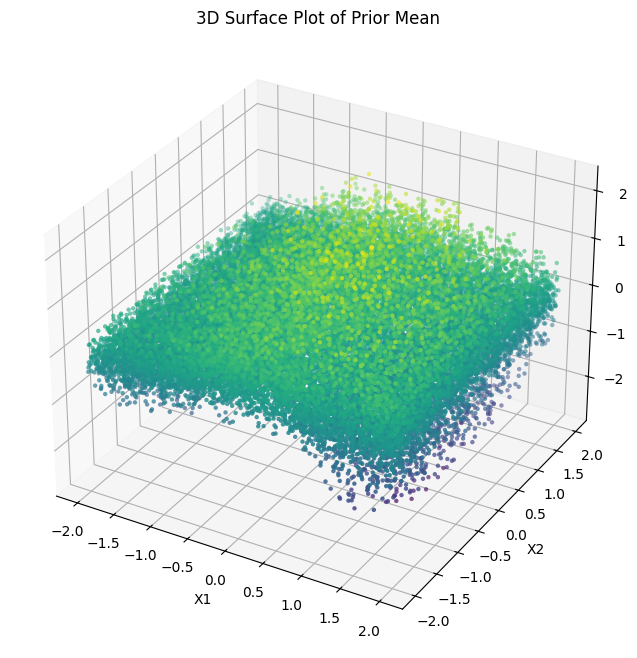

In [21]:
# plot a 3d surface of the prior
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_x[:, 0].cpu().numpy(), test_x[:, 4].cpu().numpy(), test_y.cpu().numpy(), 
           c=test_y.cpu().numpy(), cmap='viridis', edgecolor='none', s=10)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Prior Mean')
ax.set_title('3D Surface Plot of Prior Mean')
plt.show()

In [22]:
# save this dataset test_x and test_y as csv files
np.savetxt("dataset4x_6d_32400.csv", test_x.cpu().numpy(), delimiter=",")

test_y = test_y.flatten()
np.savetxt("dataset4y_6d_32400.csv", test_y, delimiter=",")